# Train a random-forest classifier

In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv("../../data/processed/stanford-all.csv", index_col=0)

In [3]:
df.shape

(31014, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31014 entries, 0 to 31013
Data columns (total 2 columns):
content    31014 non-null object
label      31014 non-null int64
dtypes: int64(1), object(1)
memory usage: 726.9+ KB


In [5]:
nlp = spacy.load("en_core_web_md")

In [6]:
docs = list(nlp.pipe(df['content']))

### Vectors visualization

Here we take the document vectors from Spacy.

In [7]:
vector_matrix = np.array(list(map(lambda x: x.vector, docs)))

In [8]:
vector_matrix.shape

(31014, 300)

We use PCA to project the vectors to their principal components.

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(.5)

In [11]:
x_pca = pca.fit_transform(vector_matrix)

In [12]:
x_pca.shape

(31014, 5)

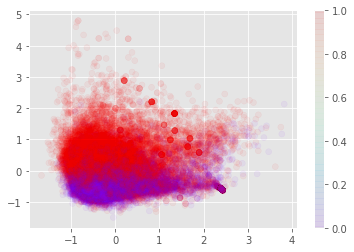

In [13]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=df['label'].tolist(), alpha=.05, cmap='rainbow');
plt.colorbar();

## Random forest classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [16]:
from sklearn.model_selection import train_test_split

### Train-test split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    vector_matrix,
    df['label'].tolist(),
    train_size=.8,
    random_state=42,
)

In [18]:
x_train.shape

(24811, 300)

In [19]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [20]:
y_pred = rf.predict(x_test)

In [21]:
y_proba = rf.predict_proba(x_test)

In [22]:
from sklearn.metrics import auc

In [23]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve

In [24]:
f1_score(y_test, y_pred)

0.8171098845960862

In [25]:
f1_score(y_train, rf.predict(x_train))

0.9877826059575541

In [26]:
y_pred

array([0, 1, 1, ..., 0, 1, 1])

In [27]:
y_proba

array([[0.5425    , 0.4575    ],
       [0.42      , 0.58      ],
       [0.45043991, 0.54956009],
       ...,
       [0.89      , 0.11      ],
       [0.14      , 0.86      ],
       [0.26      , 0.74      ]])

In [28]:
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])

In [29]:
auc(fpr, tpr)

0.8557001596511181

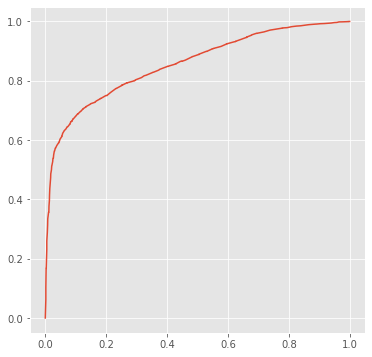

In [30]:
plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr);

In [31]:
rf.n_features_

300

In [32]:
df_train, df_test = train_test_split(
    df,
    train_size=.8,
    random_state=42,
)

In [33]:
df_train.shape

(24811, 2)

In [34]:
df_test.shape

(6203, 2)

In [35]:
df_test['prediction'] = y_proba[:, 1]

/home/guzzo/anaconda3/envs/find-out/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Let's take a look at what the model predicts.

In [36]:
df_test[df_test['prediction']>.5].sort_values('prediction', ascending=False)['content'].tolist()

['bitch we turnt hoe! https//t.co/KtYcI2Yzif',
 '@Ayola_M This bitch crazy',
 '@dontarioGirl hey whore',
 '@sadpussyjuice Shut up whore',
 'Bruh Clash is a fucking bitch lmaoo I cant stand that bald bitch. Shits annoying when she aint banned in rank https//t.co/XYzul3vf2k',
 '@pkjimin69 damn right Im a whore',
 'do u think when god made me he was like ure gonna be a furry loving omega fucking whore',
 '@h2gkmo @ArianaGrande Bitch what',
 'attention whore https//t.co/2Ysw3aywDe',
 'Lmao Im about to beat this bitch ass. She got one more time.',
 '@lomlxherron walk in and just say im outta this bitch then leave',
 '@tgrwods fucking bitch',
 '@svftsonny YAS BITCH',
 'Dumb ass fucking bitch',
 '@annecristel_ Coz i dont give a fuck bitch',
 '@DUALIPA FUCK You With this bitch @bellahadid https//t.co/D9VA6yYVHz',
 'I hate this bitch https//t.co/mAZF61bKCh',
 '@SIGARlLYO Pwediepie bitch',
 'A bitch could neverrrrrrr make me mad with a nigga who ruined my life. You next bitch tf',
 'i hate this 

In [37]:
df_test[df_test['prediction']<=.5].sort_values('prediction', ascending=False)['content'].tolist()

['Your current success catalyzes unusual patterns in your daily ... More for Sagittarius https//t.co/k7VPgaYu3K',
 '@andypbr0wn @aaronhenry313 @NicolaSturgeon Exactly, no hatred just pure joy',
 '@JacksonCDavis @nowthisnews @AOC @AyannaPressley @RashidaTlaib Lol',
 '@ThunderingScot @STVNews @NicolaSturgeon Wow head in the sand eh? You were told a no deal brexit will damage Scotland and RUK is thst what you want? Where is prove? Show me the UK treasury account books i bet you cant John probe me wrong or pipe down!!!',
 'Cleaning the house. Noticing that every doorway has a dirty spot at the height of dog noses. Im washing doorways. Dogs are gross',
 'THE SOUNDS HE MAKES KWJSJWJDJQJSJJWJSNDIE https//t.co/SY398MPy4o',
 "Is spanking appropriate for toilet training? Short answer no. Longer, more nuanced answer sometimes. Here's my take on the subject... https//t.co/2s2iR7TXkO https//t.co/1kXfhE5XKN",
 'its a dirty business but the world stays how it is.',
 '@elefantvanishes That was a dirty

### Visualization of probability distribution

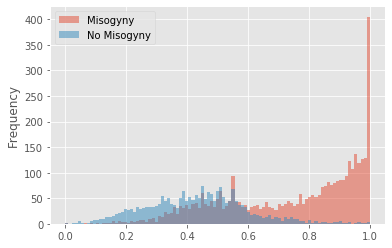

In [40]:
df_test['prediction'][df_test['label']==1].plot.hist(bins=99, alpha=.5, label="Misogyny")
df_test['prediction'][df_test['label']!=1].plot.hist(bins=99, alpha=.5, label="No Misogyny");
plt.legend();

### Parameter Optimization

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
estimator = RandomForestClassifier(n_jobs=-1, random_state=42)

In [46]:
param_grid = {
    "n_estimators": [50, 200],
#     "max_depth": [3, None],
#     "max_features": [1, 10, 100],
#     "min_samples_split": [10, 100, 1000],
#     "bootstrap": [True, False],
#     "criterion": ["gini", "entropy"],
}

In [49]:
grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=5, iid=False, verbose=2)

In [50]:
%%time
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. n_estimators=50, total=   5.7s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] .................................. n_estimators=50, total=   6.0s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   6.0s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   6.1s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   6.1s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=  18.5s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=  18.3s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=  18.6s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished


CPU times: user 2min 51s, sys: 2.95 s, total: 2min 54s
Wall time: 2min 23s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=None, param_grid={'n_estimators': [

In [51]:
grid_search.cv_results_

{'mean_fit_time': array([ 5.88121247, 18.49537921]),
 'std_fit_time': array([0.17596268, 0.17807688]),
 'mean_score_time': array([0.11226716, 0.10792713]),
 'std_score_time': array([0.00144934, 0.00059545]),
 'param_n_estimators': masked_array(data=[50, 200],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50}, {'n_estimators': 200}],
 'split0_test_score': array([0.76365102, 0.76788233]),
 'split1_test_score': array([0.76606891, 0.77795688]),
 'split2_test_score': array([0.76501411, 0.76884321]),
 'split3_test_score': array([0.76380492, 0.76501411]),
 'split4_test_score': array([0.76476517, 0.76657932]),
 'mean_test_score': array([0.76466082, 0.76925517]),
 'std_test_score': array([0.00087985, 0.00453698]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [52]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
f1_score(y_test, grid_search.predict(x_test))

0.8189134808853119

In [55]:
y_proba = grid_search.predict_proba(x_test)[:, 1]

In [56]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

In [57]:
auc(fpr, tpr)

0.8577993096851998

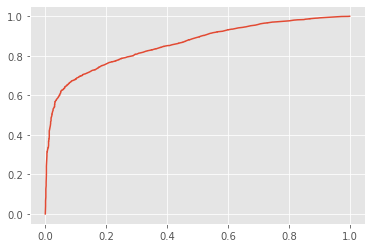

In [58]:
plt.plot(fpr, tpr)

In [ ]:
def plot_roc_auc(fpr, tpr):
    plt.subplots(figsize=(6,6))
    plt.plot(fpr, tpr)